In [512]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
from scipy.integrate import quad

In [513]:
def Radon_Nikodym_derivative(dist_pi, dist_mu, a_n):
    RN = dist_pi.log_prob(a_n) - dist_mu.log_prob(a_n)
    return RN

In [514]:
class SoftLQREnvironment:
    def __init__(self, H, M, C, D, R, sigma, T, N, tau, gamma):
        """
        SoftLQR: 带熵正则的 LQR 问题
        状态方程： dX = (H X + M a )dt + sigma dW
        成本： ∫ (x^T C x + a^T D a + tau ln p(a|x)) dt + x_T^T R x_T
        控制策略： a ~ N(mean, cov)
        其中 mean = -D_eff^{-1} M^T S(t)x,  cov = tau * D_eff,
        D_eff = D + (tau/(2*gamma^2)) I.
        """
        self.H = H
        self.M = M
        self.C = C
        self.D = D
        self.R = R
        self.sigma = sigma
        self.T = T
        self.N = N
        self.dt = T/N
        self.time_grid = torch.linspace(0, T, N+1)
        self.tau = tau
        self.gamma = gamma
        self.D_eff = self.D + (self.tau / (2 * (self.gamma ** 2))) * torch.eye(2)
        self.dist_mu = MultivariateNormal(torch.zeros(2), gamma**2*torch.eye(2))
        self.S_values = self.solve_riccati_ode()
    
    def riccati_ode(self, t, S_flat):
        """Riccati ODE 求解函数，转换为向量形式"""
        S = torch.tensor(S_flat, dtype=torch.float32).reshape(2,2) # 2x2 矩阵
        S_dot = S.T @ self.M @ torch.linalg.inv(self.D_eff) @ self.M.T @ S - self.H.T @ S - S @ self.H - self.C
        return S_dot.flatten()
    
    def solve_riccati_ode(self):
        """使用 solve_ivp 求解 Riccati ODE"""
        S_T = self.R.flatten()  # 终止条件 S(T) = R
        indices = torch.arange(self.time_grid.size(0) - 1, -1, -1)  # 生成倒序索引
        time_grid_re = torch.index_select(self.time_grid, 0, indices)
        sol = solve_ivp(self.riccati_ode, [self.T, 0], S_T, t_eval = time_grid_re, atol = 1e-10, rtol = 1e-10)  # 逆向求解
        S_matrices = sol.y.T[::-1].reshape(-1, 2, 2)  # 转换回矩阵格式
        return dict(zip(tuple(self.time_grid.tolist()), S_matrices))

    def get_nearest_S(self, t):
        """找到最近的 S(t)"""
        nearest_t = self.time_grid[torch.argmin(torch.abs(self.time_grid - t))]
        return self.S_values[nearest_t.tolist()]
    
    def value_function(self, t, x):
        """计算新的 v(t, x) = x^T S(t) x + ∫[t,T] tr(σσ^T S(r)) dr + (T-t)C_{D,tau, gamma}"""
        # 第一部分：x^T S(t) x
        S_t = self.get_nearest_S(t)
        S_t = torch.tensor(S_t, dtype = torch.float32)
        value = x.T @ S_t @ x
        
        # 第二部分：积分项 ∫[t,T] tr(σσ^T S(r)) dr
        def integrand(r):
            S_r = self.get_nearest_S(r)
            return torch.trace(self.sigma @ self.sigma.T @ S_r)
        
        integral, _ = quad(integrand, t, self.T)  # 使用数值积分计算积分项
        value += integral

        # 第三部分：(T-t)C_{D,tau, gamma}
        # C_{D,tau, gamma} = -tau ln(tau^{m/2}/gamma^{m} * det(∑)^{1/2}), ∑-1 = D+tau/(2*gamma^2)I
        inv_matrix = torch.linalg.inv(self.D_eff)
        det_matrix = torch.det(inv_matrix)
        C = - self.tau * torch.log((self.tau / self.gamma ** 2) * torch.sqrt(det_matrix))
        entropic = (self.T - t) * C
        value += entropic

        return value
    
    def optimal_control(self, t, x):
        """计算最优控制分布 pi(·|t, x) = N(-(D+tau/(2*gamma^2)I)^(-1) M^T S(t) x, tau(D+tau/(2*gamma^2)I))"""
        S_t = self.get_nearest_S(t)
        S_t = torch.tensor(S_t, dtype=torch.float32)
        # mean
        mean_control = -torch.linalg.inv(self.D_eff) @ self.M.T @ S_t @ x
        # covarian
        cov_control = self.tau * self.D_eff
        # distribution
        control_dist = MultivariateNormal(mean_control, cov_control)
        return control_dist
    
    def reset(self):
        x0 = torch.tensor([torch.empty(1).uniform_(-2, 2), torch.empty(1).uniform_(-2, 2)], dtype = torch.float32)
        return x0
    
    def simulate_trajectory(self, x0, dW):
        """
        Use Euler scheme to simulate soft LQR trajectory
        Explicit Euler:
            X_tn+1 = X_tn + dt [H X_tn - M D^{-1} M^{T} S(tn) X_tn )] + σ(W_tn+1 - W_tn ),

        Input:
            x0: Initial x
            dW: Brownian motion
        Output:
            np.array(x_traj): the LQR trajectory of x for the given x0, dW
            cost_opt_cum: the cumulative cost for the given x0, dW
        """
        x_traj = [x0.numpy()]
        cost_opt = []
        x_tn = x0
        
        for n in range(self.N):
            tn = n * self.dt
            S_tn = self.get_nearest_S(tn)
            S_tn = torch.tensor(S_tn, dtype = torch.float32)

            # mean
            mean_control = -torch.linalg.inv(self.D_eff) @ self.M.T @ S_tn @ x_tn     
            
            # covarian
            cov_control = self.tau * self.D_eff

            # distribution
            control_dist = MultivariateNormal(mean_control, cov_control)
            a_n = control_dist.sample()

            # cost
            cost_n = x_tn.T @ self.C @ x_tn + a_n.T @ self.D @ a_n
            # Compute log Radon-Nikodym derivative log p^θ
            log_prob = Radon_Nikodym_derivative(control_dist, self.dist_mu, a_n)
            # Compute running cost: f_tn + τ * ln p^θ
            running_cost_n = cost_n + self.tau * log_prob
            cost_opt.append(running_cost_n.unsqueeze(0))

            # drift = Hx + Ma
            drift = self.H @ x_tn + self.M @ a_n

            # noise = sigma dW
            noise = self.sigma @ dW[n]

            # explicit Euler scheme
            x_next = x_tn + drift * self.dt + noise
            x_tn = x_next
            x_traj.append(x_tn.numpy())
        
        # Terminal cost
        g_T = x_tn.T @ self.R @ x_tn
        cost_opt.append(g_T.unsqueeze(0))

        cost_opt = torch.stack(cost_opt)
        cost_opt_cum = torch.cumsum(cost_opt, dim = 0)

        return np.array(x_traj), cost_opt_cum

In [515]:
class PolicyNN(nn.Module):
    def __init__(self, hidden_size = 512):
        super(PolicyNN, self).__init__()

        self.hidden_layer1 = nn.Linear(1, hidden_size) 
        self.hidden_layer2 = nn.Linear(hidden_size, hidden_size)
        self.dim = 2

        # Output for phi 
        self.phi = nn.Linear(hidden_size, 2 * 2)
        # Output for L matrix for Sigma 
        self.sigma_L = nn.Linear(hidden_size, 2 * (2 + 1) // 2)

        # precompute 
        self.tri_indices = torch.tril_indices(self.dim, self.dim)
    
    def forward(self, t, x):
        """
        Forward pass to get the action distribution.
        Returns a MultivariateNormal distribution.
        """
        # Forward pass 
        t = t.view(-1, 1)  # Ensure t is a column vector 
        hidden = torch.relu(self.hidden_layer1(t)) 
        hidden = torch.sigmoid(self.hidden_layer2(hidden))

        # Compute phi 
        phi_flat = self.phi(hidden) 
        phi = phi_flat.view(-1, self.dim, self.dim)

        # Compute Sigma 
        L_flat = self.sigma_L(hidden) 
        # Create a lower triangular matrix L where L_flat fills the lower triangle 
        L = torch.zeros(self.dim, self.dim) 
        L[self.tri_indices[0], self.tri_indices[1]] = L_flat 
        
        # Compute Sigma = LL^T to ensure positive semi-definiteness 
        Sigma = L @ L.T + 1e-4*torch.eye(2).unsqueeze(0)

        # mean
        mean = phi @ x
        # variance
        cov_matirx = Sigma

        return MultivariateNormal(mean, cov_matirx)


In [516]:
class ValueNN(nn.Module):
    def __init__(self, hidden_size = 512):
        super(ValueNN, self).__init__()

        self.l1 = nn.Linear(1, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.matrix = nn.Linear(hidden_size,4) # =>2x2
        self.offset = nn.Linear(hidden_size,1)
        self.relu = nn.ReLU()

    def forward(self, t, x):
        """
        t: (batch,1)
        x: (batch,2)
        => v(t,x) = x^T [Q(t)] x + offset(t)
        Q(t) = sym( net(t) ) + diag(1e-3)
        """
        if not isinstance(t, torch.Tensor):
            t = torch.tensor([t], dtype=torch.float32)

        h = self.relu(self.l1(t))
        h = self.relu(self.l2(h))
        matrix = self.matrix(h)      # (batch,4)
        offset = self.offset(h)      # (batch,1)

        # reshape => 2x2
        matrix_2x2 = matrix.view(-1,2,2)
        matrix_sym = 0.5*(matrix_2x2 + matrix_2x2.transpose(1,2))
        # Make the matrix positive definite(存疑)
        matrix_pd = matrix_sym + 1e-3 * torch.eye(2)
        
        batch_size = x.size(0)
        x_reshaped = x.view(batch_size, 2, 1)
        quad_term = torch.bmm(torch.bmm(x_reshaped.transpose(1,2), matrix_pd), x_reshaped).view(-1)

        return quad_term + offset.squeeze(-1)
    
    def value_function(self, t, x):
        t = torch.tensor([t], dtype=torch.float32)
        x = x.view(1,2).float()
        return self.forward(t, x).item()

In [517]:
# class ValueNN(nn.Module):
#     """
#     输入 (t, x1, x2) -> 输出 V(t,x)
#     """
#     def __init__(self, hidden_size = 512):
#         super().__init__()
#         self.l1 = nn.Linear(3, hidden_size)
#         self.l2 = nn.Linear(hidden_size, hidden_size)
#         self.out = nn.Linear(hidden_size,1)

#     def forward(self, t, x):
#         inp = torch.cat([t, x], dim=1)
#         h = torch.relu(self.l1(inp))
#         h = torch.relu(self.l2(h))
#         v = self.out(h).squeeze(-1)
#         return v

In [518]:
# test
H = torch.tensor([[1.0, 1.0], [0.0, 1.0]]) * 0.5
M = torch.tensor([[1.0, 1.0], [0.0, 1.0]])
sigma = torch.eye(2) * 0.5 # 可以试0.0
C = torch.tensor([[1.0, 0.1], [0.1, 1.0]]) * 1.0
# D = torch.tensor([[1.0, 0.1], [0.1, 1.0]]) * 0.1
D = torch.eye(2)
R = torch.tensor([[1.0, 0.3], [0.3, 1.0]]) * 10.0
T = 0.5
N = 100

tau = 0.1
gamma = 10
x0 = torch.tensor([2.0,2.0])
# torch.manual_seed(1234)
dW = torch.randn(N, 2) * np.sqrt(T/N)
n_episodes = 25000
lr_actor = 1e-4
lr_critic = 1e-1

In [519]:
# def OfflineActorCritic1(env, policyNN, valueNN, n_episodes, lr_actor = 5e-4, lr_critic = 5e-4):
#     """
#     Trains a policy and value network using an offline Actor-Critic algorithm with entropy regularization

#     Input:
#         env: A soft LQR environment
#         policyNN: Policy neural network that outputs a distribution given t, x.
#         valueNN: Value function neural network that approximates V(t, x).
#         n_episodes: Number of training episodes.
#         lr_actor: Learning rate for the actor (policyNN).
#         lr_critic: Learning rate for the critic (valueNN). 
#     Output:
#         cost_history: Total running cost for every episode.
#         criticloss: Critic loss for every episode.
#     """
#     # Create optimizers for policyNN and valueNN
#     actor_optim = optim.Adam(policyNN.parameters(), lr = lr_actor)
#     critic_optim = optim.Adam(valueNN.parameters(), lr = lr_critic)

#     cost_history = []
#     criticloss = []

#     # Start to train
#     for ep in range(n_episodes):
#         # Sample x0
#         x0 = env.reset()
#         x_tn = x0

#         t_list = []
#         x_list = []
#         a_list = []
#         cost_list = []
#         logp_list = []

#         # Simulate a trajectory
#         for n in range(env.N):
#             # Forward
#             tn = n * env.dt
#             tn = torch.tensor([[tn]], dtype = torch.float32)

#             # Use policy neural network to output a distribution
#             dist = policyNN.forward(tn, x_tn)    
#             # Sample action a_n from distribution
#             a_n = dist.sample().squeeze()

#             # Compute log Radon-Nikodym derivative log p^θ
#             log_prob = Radon_Nikodym_derivative(dist, env.dist_mu, a_n)

#             # Apply action a_n in environment
#             # cost f_tn
#             cost_n = (x_tn.T @ env.C @ x_tn) + (a_n.T @ env.D @ a_n)

#             # Use explicit euler to get new state x_tn+1
#             drift = env.H @ x_tn + env.M @ a_n
#             noise = env.sigma @ torch.randn(2) * np.sqrt(env.dt)
#             x_next = x_tn + drift * env.dt + noise

#             # Store data
#             t_list.append(tn)
#             x_list.append(x_tn)
#             a_list.append(a_n)
#             cost_list.append(cost_n)
#             logp_list.append(log_prob)

#             # Update
#             x_tn = x_next
#         x_T = x_tn
#         # Terminal cost
#         g_T = x_T.T @ env.R @ x_T

#         # Convert list to torch.tensor
#         t = torch.tensor(t_list).float().view(-1,1)
#         x = torch.stack(x_list)
#         cost = torch.stack(cost_list)
#         logprob = torch.stack(logp_list)

#         # Use value function neural network to approximate v(t, x)
#         v_n = valueNN(t, x)
#         # Compute v_next(t, x)
#         t_next = t + env.dt
#         x_next_list = []
#         for i in range(env.N - 1):
#             x_next_list .append(x[i + 1])
#         x_next_list.append(x_T.view(1,2)[0])
#         x_next_list = torch.stack(x_next_list, dim = 0)
#         v_next = valueNN(t_next, x_next_list)

#         # Compute running cost: f_tn + τ * ln p^θ
#         running_cost = cost + env.tau * logprob
#         # Compute total cost: running_cost + terminal cost
#         total_cost = running_cost + g_T
#         cost_history.append(sum(total_cost))

#         # Updata Actor
#         actor_optim.zero_grad()
#         # Compute inside term: ((∆vθn) + [ftn + τ ln pθ(αtn |tn, Xtn )](∆t)) .
#         inside_list = []
#         for n in range(env.N):
#             delta_v = (v_next[n] - v_n[n]).detach()
#             inside = delta_v + running_cost[n] * env.dt
#             inside_list.append(inside)
#         inside_term = torch.stack(inside_list, dim = 0)
#         G_hat = -(inside_term * logprob).sum()
#         G_hat.backward()
#         actor_optim.step()

#         # Update Critic 
#         critic_optim.zero_grad()
        
#         # Precompute cumulative sum
#         pre_cumsum = torch.cumsum(running_cost, dim = 0) * env.dt
#         total_cumsum = pre_cumsum[-1]

#         # Compute target term: - (sum_{k=n}^{N-1} (f_tk + τ ln pθ(αtk |tk, Xtk ))(∆t) + gtN )
#         targets = []
#         for n in range(env.N):
#             target_term = (total_cumsum - pre_cumsum[n]) + g_T
#             targets.append(target_term)
#         targets = torch.stack(targets, dim = 0)

#         # Compute L(η)
#         td = v_n - targets.detach()
#         critic_loss = (td ** 2).sum()
#         criticloss.append(critic_loss)
#         critic_loss.backward()
#         critic_optim.step()

#         if ep % 500 == 0:
#                 print(f"[Ep {ep}/{n_episodes}] CriticLoss={critic_loss.item():.4f}, ActorGrad = {G_hat.item():.4f}")
    
#     return cost_history, criticloss

In [520]:
def OfflineActorCritic(env, policyNN, valueNN, n_episodes, lr_actor = 5e-4, lr_critic = 5e-4):
    actor_optim = optim.Adam(policyNN.parameters(), lr = lr_actor)
    critic_optim = optim.Adam(valueNN.parameters(), lr = lr_critic)
    cost_history = []
    criticloss = []
    for ep in range(n_episodes):
        # x0 = torch.tensor([2.0,2.0])
        x0 = torch.tensor([torch.empty(1).uniform_(-2, 2), torch.empty(1).uniform_(-2, 2)], dtype = torch.float32)
        x_tn = x0

        t_list = []
        x_list = []
        a_list = []
        cost_list = []
        logp_list = []
        
        for n in range(env.N):
            # forward
            tn = n*env.dt
            tn = torch.tensor([[tn]], dtype = torch.float32)
            x_tn = x_tn

            dist = policyNN.forward(tn,x_tn)    
            a_n = dist.sample().squeeze()

            log_prob = Radon_Nikodym_derivative(dist, env.dist_mu, a_n)

            # cost
            cost_n = (x_tn.T @ env.C @ x_tn) + (a_n.T @ env.D @ a_n)

            # 存储
            t_list.append(tn)
            x_list.append(x_tn)
            a_list.append(a_n)
            cost_list.append(cost_n)
            logp_list.append(log_prob)

            # 显式Euler
            drift = env.H @ x_tn + env.M @ a_n
            noise = env.sigma @ torch.randn(2)
            x_next = x_tn + drift*env.dt + noise*np.sqrt(env.dt)

            x_tn = x_next
        
        x_T = x_tn

        critic_optim.zero_grad()
        t_tensor = torch.tensor(t_list).float().view(-1,1)
        x_tensor = torch.stack(x_list)
        v_n = valueNN(t_tensor, x_tensor)
        cost_n = torch.stack(cost_list)
        logp_n = torch.stack(logp_list)

        stage_val = cost_n + env.tau*logp_n
        prefix_sum = torch.cumsum(stage_val, dim=0)*env.dt
        final_val = prefix_sum[-1]
        g_T = x_T.T @ env.R @ x_T
        targets = []
        for n in range(env.N):
            t_n = (final_val - prefix_sum[n]) - g_T
            targets.append(t_n)
        targets = torch.stack(targets, dim=0)
        cost_history.append(sum(cost_n))

        td = v_n - targets.detach()
        # critic_loss = 0.5*(td**2).mean() ##????
        critic_loss = (td**2).sum()
        criticloss.append(critic_loss)
        critic_loss.backward()
        critic_optim.step()

        # v_{n+1}:
        actor_optim.zero_grad()
        t_np1 = t_tensor + env.dt
        x_np1_list = []
        for i in range(env.N-1):
            x_np1_list.append(x_tensor[i+1])
        x_np1_list.append(x_T.view(1,2)[0])  # 替换成终端
        x_np1_ten = torch.stack(x_np1_list, dim=0)
        v_np1 = valueNN(t_np1, x_np1_ten)

        inside_list = []
        for n in range(N):
            delta_v = (v_np1[n] - v_n[n]).detach()  # 不回传 Critic梯度
            inside = delta_v + stage_val[n]*env.dt
            inside_list.append(inside)
        inside_ten = torch.stack(inside_list, dim=0)
        # G_hat = -(inside_ten * logp_n).mean()
        G_hat = -(inside_ten * logp_n).sum()
        G_hat.backward()
        actor_optim.step()

        if (ep+1)%500 == 0:
                print(f"[Ep {ep+1}/{n_episodes}] CriticLoss={critic_loss.item():.4f}, ActorLoss={G_hat.item():.4f}")
    return cost_history, criticloss

In [521]:
env = SoftLQREnvironment(H, M, C, D, R, sigma, T, N, tau, gamma)

In [522]:
actor = PolicyNN(hidden_size = 256)
critic = ValueNN(hidden_size = 512)

In [523]:
cost_history, criticloss = OfflineActorCritic(env, actor, critic, n_episodes, lr_actor, lr_critic)

[Ep 500/25000] CriticLoss=275647.0938, ActorLoss=16700.0859
[Ep 1000/25000] CriticLoss=968767.7500, ActorLoss=-41695.5625
[Ep 1500/25000] CriticLoss=801161.1250, ActorLoss=3708.8115
[Ep 2000/25000] CriticLoss=188387.6094, ActorLoss=23014.0000
[Ep 2500/25000] CriticLoss=2802750.0000, ActorLoss=-27457.8613
[Ep 3000/25000] CriticLoss=106267.4219, ActorLoss=1557.0403
[Ep 3500/25000] CriticLoss=129672.8828, ActorLoss=-4129.2129
[Ep 4000/25000] CriticLoss=351226.4062, ActorLoss=8995.1182
[Ep 4500/25000] CriticLoss=140791.0938, ActorLoss=-10874.8555
[Ep 5000/25000] CriticLoss=161696.8438, ActorLoss=-4903.4775
[Ep 5500/25000] CriticLoss=34994.9492, ActorLoss=1081.9694
[Ep 6000/25000] CriticLoss=4578.6143, ActorLoss=-1143.8796
[Ep 6500/25000] CriticLoss=215414.4062, ActorLoss=1015.4935
[Ep 7000/25000] CriticLoss=207782.5625, ActorLoss=7400.9580
[Ep 7500/25000] CriticLoss=63033.5781, ActorLoss=-1784.1646
[Ep 8000/25000] CriticLoss=33973.8203, ActorLoss=-3706.7119
[Ep 8500/25000] CriticLoss=25313

In [524]:
print(criticloss)
critic_loss = torch.stack(criticloss).tolist()
print(critic_loss)

[tensor(24579.2656, grad_fn=<SumBackward0>), tensor(8.6790e+09, grad_fn=<SumBackward0>), tensor(2.0648e+09, grad_fn=<SumBackward0>), tensor(4.4275e+08, grad_fn=<SumBackward0>), tensor(1.2368e+08, grad_fn=<SumBackward0>), tensor(97144048., grad_fn=<SumBackward0>), tensor(11742692., grad_fn=<SumBackward0>), tensor(2.1743e+08, grad_fn=<SumBackward0>), tensor(16465198., grad_fn=<SumBackward0>), tensor(43548096., grad_fn=<SumBackward0>), tensor(1025727.8125, grad_fn=<SumBackward0>), tensor(53634600., grad_fn=<SumBackward0>), tensor(49209856., grad_fn=<SumBackward0>), tensor(15639173., grad_fn=<SumBackward0>), tensor(16636374., grad_fn=<SumBackward0>), tensor(7642985., grad_fn=<SumBackward0>), tensor(8284846., grad_fn=<SumBackward0>), tensor(11038032., grad_fn=<SumBackward0>), tensor(13786889., grad_fn=<SumBackward0>), tensor(5030063., grad_fn=<SumBackward0>), tensor(2437873.7500, grad_fn=<SumBackward0>), tensor(24308816., grad_fn=<SumBackward0>), tensor(186512.4688, grad_fn=<SumBackward0>),

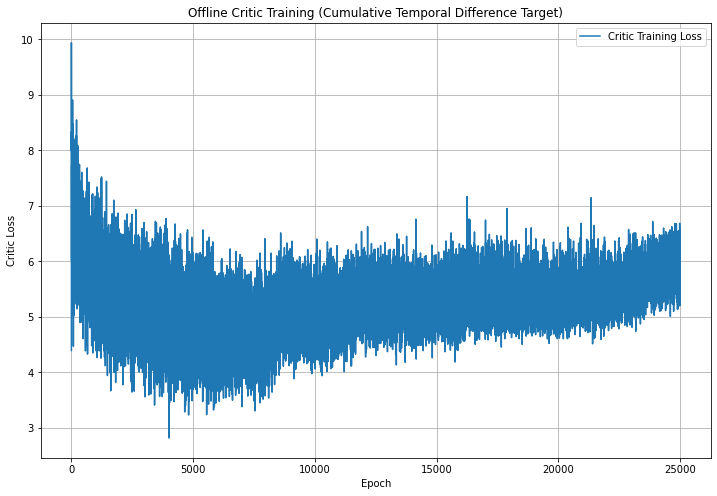

In [525]:
plt.figure(figsize = (12,8))
plt.plot(np.log10(critic_loss), label='Critic Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Critic Loss')
plt.title('Offline Critic Training (Cumulative Temporal Difference Target)')
plt.grid(True)
plt.legend()
plt.show()

In [526]:
data = np.array(critic_loss)  # 原始数据转换为 NumPy 数组
chunk_size = 500

# 保证长度是 chunk_size 的整数倍（可以裁剪或补0）
num_chunks = len(data) // chunk_size
print(num_chunks)
data_trimmed = data[:num_chunks * chunk_size]

# reshape 为 (num_chunks, chunk_size)，按行求均值
averages = data_trimmed.reshape(-1, chunk_size).mean(axis=1)
print(averages)

50
[38747179.6343125   1852180.249125    1325781.16887305   754254.93549121
   511110.52359863   368202.44238379   350407.90826318   342103.58316895
   266026.84379614   187001.77774878   165904.76928125   141004.55782129
   118162.71186084   132499.30309424   103895.09648437   114693.96239648
   126236.61139844   227719.91506836   203726.72004492   175287.63062305
   196682.15658789   222184.60836719   240401.02154688   279229.92074609
   292004.44411328   276428.95725391   272201.47693359   277645.96938672
   263471.80117578   258108.609625     275665.57234375   297598.28439258
   435424.37639844   307206.38292187   327266.40815625   324803.13268359
   313926.72075      316024.75659375   269630.50070313   290287.4105625
   299278.50030469   299387.97015625   370128.39186719   327193.94316406
   360348.28097656   402759.05232812   519711.28517187   610519.23676562
   763444.07048437   903289.46685938]


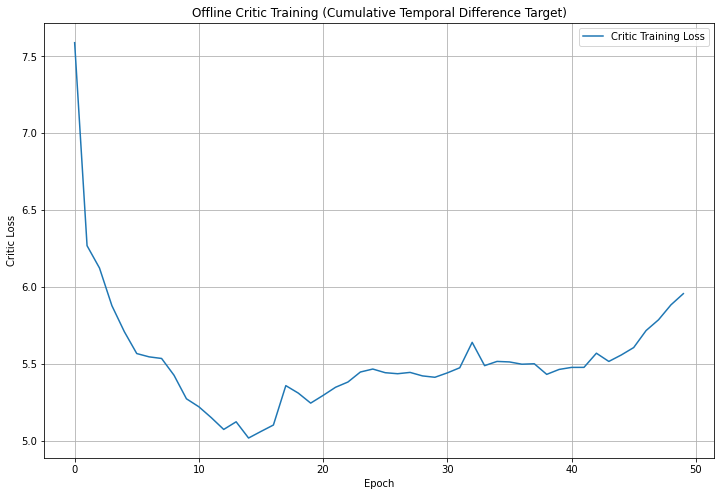

In [527]:
plt.figure(figsize = (12,8))
plt.plot(np.log10(averages), label='Critic Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Critic Loss')
plt.title('Offline Critic Training (Cumulative Temporal Difference Target)')
plt.grid(True)
plt.legend()
plt.show()

In [528]:
# x_traj = env.simulate_trajectory(x0, dW)
# print(x_traj)
# plt.figure(figsize = (12,8))
# plt.plot(x_traj[:,0], x_traj[:,1], label="Learned Offline AC")

In [529]:
# 神经网络训练
x0 = torch.tensor([2.0, -2.0])
dt = 0.5/100
# torch.manual_seed(1234)
dW = torch.randn(100, 2) * np.sqrt(env.dt)
x_tn = x0.clone()
x_traj_learn = []
cost_learn = []
for n in range(100):
    tn = n * dt
    tn = torch.tensor([tn], dtype=torch.float32)
    dist = actor.forward(tn, x_tn)
    a_n = dist.sample().squeeze()
    # print(a_n)

    # cost
    cost_n = x_tn.T @ env.C @ x_tn + a_n.T @ env.D @ a_n
    # print(a_n.T @ env.D @ a_n)
    cost_learn.append(cost_n)

    # drift = Hx + Ma
    drift = env.H @ x_tn + env.M @ a_n
    # noise = sigma dW
    noise = env.sigma @ dW[n]
    # Euler–Maruyama 更新状态
    x_next = x_tn + drift * env.dt + noise
    x_traj_learn.append(x_tn.numpy())
    x_tn = x_next
# terminal cost
g_T = x_tn.T @ env.R @ x_tn
cost_learn.append(g_T)
x_traj_learn = np.array(x_traj_learn)
cost_learn = torch.stack(cost_learn)
# print(cost_learn.size())
# print(torch.cumsum(cost_learn, dim=0))
cost_learn = torch.cumsum(cost_learn, dim=0)

In [530]:
def simulate_trajectory(env, x0, dW):
        """
        使用 Euler 方法模拟 soft LQR 轨迹
        """
        x_traj = [x0.numpy()]
        cost_opt = []
        x_tn = x0
        
        dt = env.dt
        for n in range(env.N):
            tn = n * dt
            S_tn = env.get_nearest_S(tn)
            S_tn = torch.tensor(S_tn, dtype = torch.float32)

            # mean
            mean_control = -torch.linalg.inv(env.D_eff) @ env.M.T @ S_tn @ x_tn     
            
            # covarian
            cov_control = env.tau * env.D_eff

            # distribution
            # print(mean_control)
            control_dist = MultivariateNormal(mean_control, cov_control)
            control_a = control_dist.sample()
            # print(control_a)

            # cost
            cost_n = x_tn.T @ env.C @ x_tn + control_a.T @ env.D @ control_a
            # print(control_a.T @ env.R @ control_a)
            cost_opt.append(cost_n)
            # drift = Hx + Ma
            drift = env.H @ x_tn + env.M @ control_a

            # noise = sigma dW
            noise = env.sigma @ dW[n]

            # explicit Euler scheme
            x_next = x_tn + drift * dt + noise
            x_tn = x_next
            x_traj.append(x_tn.numpy())
        # terminal cost
        g_T = x_tn.T @ env.R @ x_tn
        cost_opt.append(g_T)

        return np.array(x_traj), cost_opt

In [531]:
x_traj_opt, cost_opt = simulate_trajectory(env, x0, dW)
cost_opt = torch.stack(cost_opt)
# print(cost_opt)
# print(torch.cumsum(cost_opt, dim=0))
cost_opt = torch.cumsum(cost_opt, dim=0)

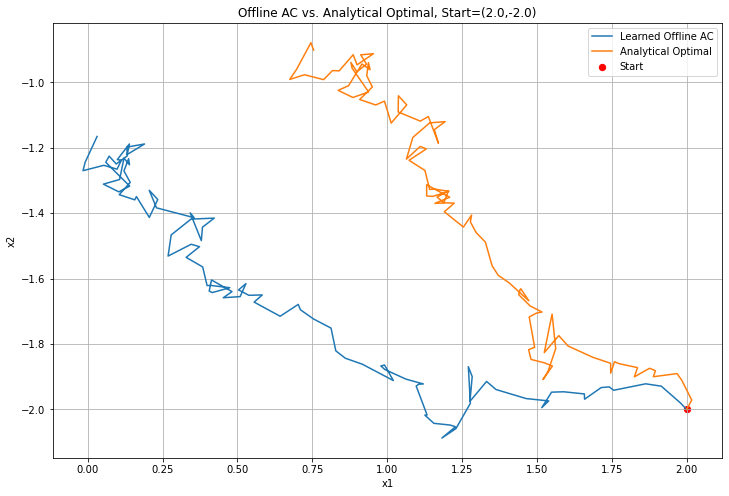

In [532]:
# 绘图
plt.figure(figsize = (12,8))
plt.plot(x_traj_learn[:,0], x_traj_learn[:,1], label="Learned Offline AC")
plt.plot(x_traj_opt[:,0], x_traj_opt[:,1], label="Analytical Optimal")
plt.scatter(x0[0].item(),x0[1].item(), color='red', s=40, label="Start")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title(f"Offline AC vs. Analytical Optimal, Start=({x0[0].item()},{x0[1].item()})")
plt.legend()
plt.grid(True)
plt.show()

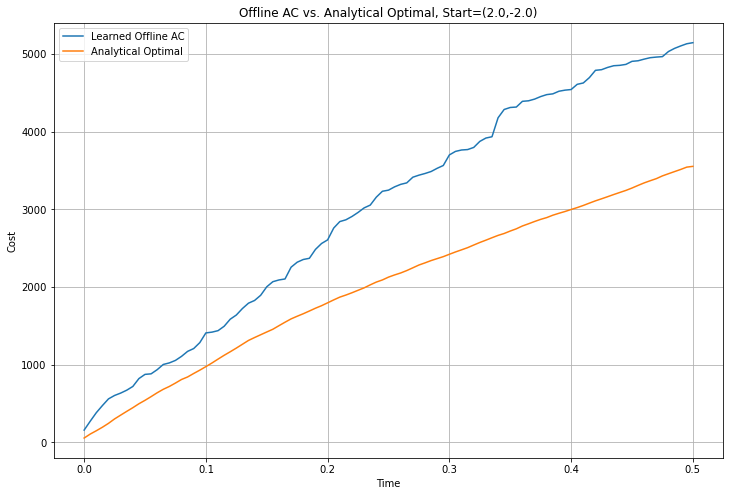

In [533]:
# 绘图
plt.figure(figsize = (12,8))
plt.plot(env.time_grid, cost_learn, label="Learned Offline AC")
plt.plot(env.time_grid, cost_opt, label="Analytical Optimal")
# plt.scatter(x0[0].item(),x0[1].item(), color='red', s=40, label="Start")
plt.xlabel("Time")
plt.ylabel("Cost")
plt.title(f"Offline AC vs. Analytical Optimal, Start=({x0[0].item()},{x0[1].item()})")
plt.legend()
plt.grid(True)
plt.show()

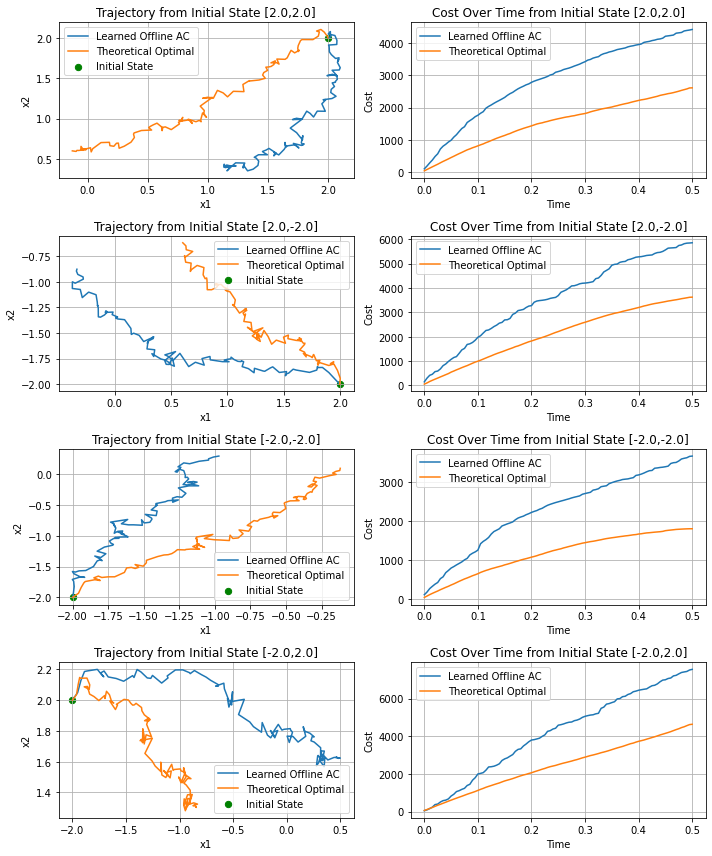

In [534]:
def training_test(env, policyNN, x0, dW):
    """
    Simulate one trajectory using the learned policy,
    and computes the cumulative cost over time.

    Input:
        env: A soft LQR environment
        policyNN: Policy neural network that outputs a distribution given t, x.
        x0: Initial state
        dW: Brownian motion
    Output:
        x_traj_learn: The simulated state trajectory under the learned policy.
        cost_learn_cum: The cumulative cost at each time step, including the terminal cost.
    """
    x_tn = x0.clone()
    x_traj_learn = []    
    cost_learn = []   
    for n in range(env.N):
        tn = n * env.dt

        S_tn = env.get_nearest_S(tn)
        S_tn = torch.tensor(S_tn, dtype = torch.float32)
        
        tn = torch.tensor([tn], dtype=torch.float32)
        # Use policy neural network to output a distribution
        dist = policyNN.forward(tn, x_tn)    
        # Sample action a_n from distribution
        a_n = dist.sample().squeeze()
        
        # cost f_tn
        cost_n = (x_tn.T @ env.C @ x_tn) + (a_n.T @ env.D @ a_n)
        # Compute log Radon-Nikodym derivative log p^θ
        log_prob = Radon_Nikodym_derivative(dist, env.dist_mu, a_n)
        # Compute running cost: f_tn + τ * ln p^θ
        running_cost_n = cost_n + env.tau * log_prob
        cost_learn.append(running_cost_n)

        # Use explicit euler to get new state x_tn+1
        drift = env.H @ x_tn + env.M @ a_n
        noise = env.sigma @ dW[n]
        x_next = x_tn + drift * env.dt + noise
        x_traj_learn.append(x_tn.numpy())
        x_tn = x_next
    # Terminal cost
    g_T = x_tn.T @ env.R @ x_tn
    cost_learn.append(g_T.unsqueeze(0))

    x_traj_learn = np.array(x_traj_learn)
    cost_learn = torch.stack(cost_learn)
    cost_learn_cum = torch.cumsum(cost_learn, dim = 0)

    return x_traj_learn, cost_learn_cum

def plot_trajectory_cost(initial_states, env, Actor, dW):
    """
    Plot state trajectories and cumulative costs over time for multiple initial states,
    comparing the learned offline Actor-Critic policy with the theoretical optimal solution.

    Input:
        initial_states: A list of initial state
        env: A soft LQR environment
        Actor: Policy neural network that outputs a distribution given t, x.
        dW: Brownian motion
    """
    fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (10, 12))

    for i, x0 in enumerate(initial_states):
        x_traj_learn, cost_learn_cum = training_test(env, Actor, x0, dW)
        x_traj_optim, cost_optim_cum = env.simulate_trajectory(x0, dW)

        axes[i, 0].plot(x_traj_learn[:,0], x_traj_learn[:,1], label = "Learned Offline AC")
        axes[i, 0].plot(x_traj_optim[:,0], x_traj_optim[:,1], label = "Theoretical Optimal")
        axes[i, 0].scatter(x0[0].item(),x0[1].item(), color = 'green', s = 40, label = "Initial State")
        axes[i, 0].set_xlabel("x1")
        axes[i, 0].set_ylabel("x2")
        axes[i, 0].set_title(f"Trajectory from Initial State [{x0[0].item()},{x0[1].item()}]")
        axes[i, 0].legend()
        axes[i, 0].grid()

        axes[i, 1].plot(env.time_grid, cost_learn_cum.detach().numpy(), label = "Learned Offline AC")
        axes[i, 1].plot(env.time_grid, cost_optim_cum, label = "Theoretical Optimal")
        axes[i, 1].set_xlabel("Time")
        axes[i, 1].set_ylabel("Cost")
        axes[i, 1].set_title(f"Cost Over Time from Initial State [{x0[0].item()},{x0[1].item()}]")
        axes[i, 1].legend()
        axes[i, 1].grid()
    
    plt.tight_layout()
    plt.show()

# Test training results
# four initial states
initial_states = torch.tensor([[2.0, 2.0], [2.0, -2.0], [-2.0, -2.0], [-2.0, 2.0]])
# torch.manual_seed(1231)
dW = torch.randn(N, 2) * np.sqrt(env.dt)

# Plot state trajectories and cumulative costs over time for multiple initial states
plot_trajectory_cost(initial_states, env, actor, dW)